# Saving and Loading Models

Neste notebook, mostrarei como salvar e carregar modelos com PyTorch. Isso é importante porque muitas vezes você desejará carregar modelos previamente treinados para usar em previsões ou para continuar o treinamento em novos dados.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import helper
import fc_model

In [3]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Here we can see one of the images.

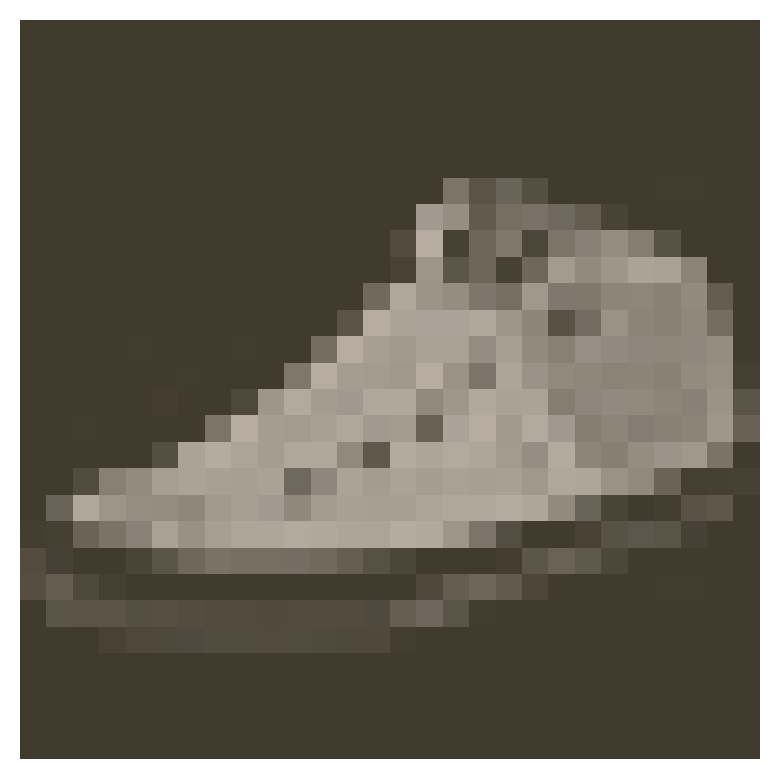

In [4]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);

# Train a network

Para tornar as coisas mais concisas aqui, movi a arquitetura do modelo e o código de treinamento da última parte para um arquivo chamado `fc_model`. Importando isso, podemos facilmente criar uma rede totalmente conectada com `fc_model.Network` e treinar a rede usando `fc_model.train`. Usarei este modelo (depois de treinado) para demonstrar como podemos salvar e carregar modelos.

In [5]:
# Create the network, define the criterion and optimizer

model = fc_model.Network(784, 10, [512, 256, 128])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
fc_model.train(model, trainloader, testloader, criterion, optimizer, epochs=2)

Epoch: 1/2..  Training Loss: 1.737..  Test Loss: 1.000..  Test Accuracy: 0.608
Epoch: 1/2..  Training Loss: 1.030..  Test Loss: 0.728..  Test Accuracy: 0.733
Epoch: 1/2..  Training Loss: 0.845..  Test Loss: 0.674..  Test Accuracy: 0.748
Epoch: 1/2..  Training Loss: 0.801..  Test Loss: 0.631..  Test Accuracy: 0.756
Epoch: 1/2..  Training Loss: 0.720..  Test Loss: 0.610..  Test Accuracy: 0.768
Epoch: 1/2..  Training Loss: 0.685..  Test Loss: 0.602..  Test Accuracy: 0.767
Epoch: 1/2..  Training Loss: 0.667..  Test Loss: 0.585..  Test Accuracy: 0.782
Epoch: 1/2..  Training Loss: 0.667..  Test Loss: 0.554..  Test Accuracy: 0.785
Epoch: 1/2..  Training Loss: 0.662..  Test Loss: 0.560..  Test Accuracy: 0.791
Epoch: 1/2..  Training Loss: 0.655..  Test Loss: 0.538..  Test Accuracy: 0.803
Epoch: 1/2..  Training Loss: 0.674..  Test Loss: 0.530..  Test Accuracy: 0.797
Epoch: 1/2..  Training Loss: 0.618..  Test Loss: 0.533..  Test Accuracy: 0.802
Epoch: 1/2..  Training Loss: 0.662..  Test Loss: 0.5

## Saving and loading networks

Como você pode imaginar, é impraticável treinar uma rede toda vez que for necessário usá-la. Em vez disso, podemos salvar redes treinadas e carregá-las posteriormente para treinar mais ou usá-las para previsões.

Os parâmetros para redes PyTorch são armazenados no `state_dict` de um modelo. Podemos ver que o ditado estadual contém as matrizes de peso e polarização para cada uma de nossas camadas.

In [8]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
) 

The state dict keys: 

 odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


A coisa mais simples a fazer é simplesmente salvar o dict do estado com `torch.save`. Por exemplo, podemos salvá-lo em um arquivo `'checkpoint.pth'`.

In [9]:
torch.save(model.state_dict(), 'checkpoint.pth')

Então podemos carregar o dict do estado com `torch.load`.

In [10]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


E para carregar o state dict na rede, você faz `model.load_state_dict(state_dict)`.

In [11]:
model.load_state_dict(state_dict)

<All keys matched successfully>

Parece bastante simples, mas como sempre é um pouco mais complicado. Carregar o dict de estado funciona apenas se a arquitetura do modelo for exatamente igual à arquitetura do ponto de verificação. Se eu criar um modelo com uma arquitetura diferente, isso falhará.

In [12]:
# Try this
model = fc_model.Network(784, 10, [400, 200, 100])
# This will throw an error because the tensor sizes are wrong!
model.load_state_dict(state_dict)

RuntimeError: Error(s) in loading state_dict for Network:
	size mismatch for hidden_layers.0.weight: copying a param with shape torch.Size([512, 784]) from checkpoint, the shape in current model is torch.Size([400, 784]).
	size mismatch for hidden_layers.0.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([400]).
	size mismatch for hidden_layers.1.weight: copying a param with shape torch.Size([256, 512]) from checkpoint, the shape in current model is torch.Size([200, 400]).
	size mismatch for hidden_layers.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for hidden_layers.2.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([100, 200]).
	size mismatch for hidden_layers.2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for output.weight: copying a param with shape torch.Size([10, 128]) from checkpoint, the shape in current model is torch.Size([10, 100]).

Isso significa que precisamos reconstruir o modelo exatamente como estava quando treinado. As informações sobre a arquitetura do modelo precisam ser salvas no ponto de verificação, junto com o dict do estado. Para fazer isso, você constrói um dicionário com todas as informações necessárias para reconstruir completamente o modelo.

In [13]:
checkpoint = {'input_size': 784,
              'output_size': 10,
              'hidden_layers': [each.out_features for each in model.hidden_layers],
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

Agora o checkpoint possui todas as informações necessárias para reconstruir o modelo treinado. Você pode facilmente transformar isso em uma função, se quiser. Da mesma forma, podemos escrever uma função para carregar pontos de verificação.

In [14]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = fc_model.Network(checkpoint['input_size'],
                             checkpoint['output_size'],
                             checkpoint['hidden_layers'])
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [15]:
model = load_checkpoint('checkpoint.pth')
print(model)

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=200, bias=True)
    (2): Linear(in_features=200, out_features=100, bias=True)
  )
  (output): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
